# Get and explore dataset

In [59]:
import matplotlib.pyplot as plt
from matplotlib import pyplot
import numpy as np
import re

In [60]:
# Make results reproducible - set random seed
from numpy.random import seed
seed(42)

In [61]:
negative_file = "negative.txt"
positive_file = "positive.txt"

In [62]:
# Do not modify - helper function to load and preprocess data
def filter_words(line):    
    line = re.sub(r'[^\w\s]','',line.rstrip())
    words = line.split(" ") 
    words = [i.lower() for i in words if i]      
    return " ".join(words)

def load_data(filename):
    thefile = open(filename, 'r') 
    lines = thefile.readlines() 

    data = []
    for l in range(0,len(lines)): 
        if(lines[l-1].strip() == "<title>"): 
            theline = filter_words(lines[l])
            if(len(theline) < 50):
                data.append(theline)            
            
    return data

# Helper function to convert categorical data to class label
def to_word_label(y):
    y = to_class(y)   
    return ["positive" if i==0 else "negative" for i in y]

# Helper function to convert class label to numeric label
def to_numeric_label(y):
  return [0 if i=="positive" else 1 for i in word_labels]

# Helper function: this function needs to be called before sending arrays to sklearn metrics,
# it converts back to class form from categorical form. ie: [1,0] --> 0, [0,1] --> 1
def to_class(y):
    return np.argmax(y,axis=1) 

In [63]:
positive = load_data(positive_file)
negative = load_data(negative_file)

print(positive[0:10])
print(negative[0:10])

['one of the best crichton novels', 'the medicine of the future', 'beautiful', 'for lovers of robicheaux', 'a good book', 'to the point and beautifully illustrated', 'at least somebody has got it', 'beautifully written heartwarming story', 'an excellent cookbook full of delicious recipes', 'an outstanding resource']
['horrible book horrible', 'shallow selfindulgence', 'horrible book horrible', 'disappointment', 'a disappointing mess', 'save your money there are better books out there', 'thank you but no thanks', 'unendurable', 'the hard way', 'some good info among the political commercial']


In [64]:
# Do not modify - Combines the positive and negative reviews into a single list and create labels
data = positive + negative
word_labels = ["positive"] * len(positive) + ["negative"] * len(negative) 

# Converts labels to numbers in one-hot encoding - [1, 0] (positive) or [0, 1] (negative)
from tensorflow.keras.utils import to_categorical
labels  = to_categorical(to_numeric_label(word_labels))

In [65]:
# - Calculate and report the mean review size, its standard deviation and create a boxplot.
X = data

# get review length
print("Review Summary")
review_len = [len(x) for x in X]

mean_review = round(np.mean(review_len),2)
print('Mean Review Size: ',mean_review)

std_review = round(np.std(review_len),3)
print('Standard Deviation: ',std_review)

Review Summary
Mean Review Size:  24.68
Standard Deviation:  11.284


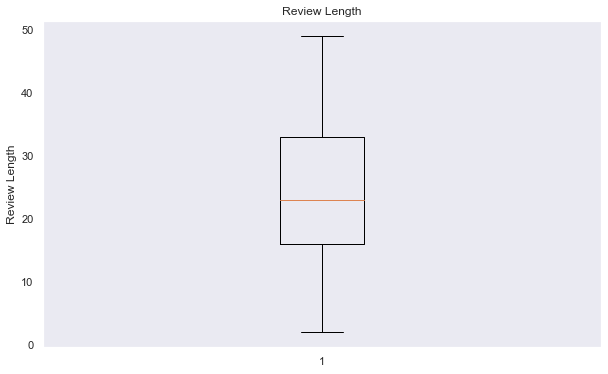

In [66]:
# import seaborn plotting library
import seaborn as sns
sns.set_theme(style='dark')

# plot review length
fig, ax = plt.subplots(figsize=(10,6))
plt.boxplot(review_len)
plt.title("Review Length")
plt.ylabel("Review Length")
plt.show()

In [67]:
# - Calculate the number of unique words in the dataset
words = np.unique(np.hstack(X))
words_len = len(words)
print('Number of words: ',words_len)

Number of words:  1676


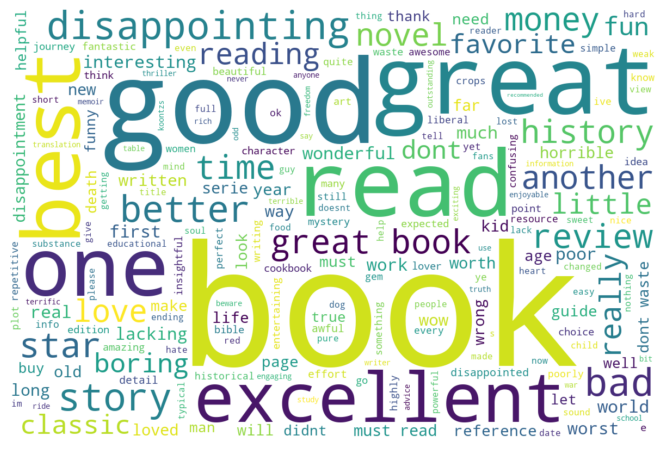

In [68]:
# Perform any other dataset investigation that you feel would be valuable

# Creating a WordCloud based off of data
from wordcloud import WordCloud, STOPWORDS

# Preparing the data
text = " ".join(data)

# Build and display wordcloud
word = WordCloud(width=1200, height=800, margin=10, background_color='white').generate(text)
plt.figure(figsize=(12,8))
plt.imshow(word, interpolation='bilinear')
plt.axis("off")
plt.margins(x=0, y=0)



In [69]:
# Do not modify - Tokenize the vocabulary 
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words=25)

tokenizer.fit_on_texts(data) #create the vocabularry

tokenized_data = tokenizer.texts_to_sequences(data) #tokenize the data using the vocabulary

vocab_size = len(tokenizer.word_index) + 1 

# Compare a sample of the data before and after tokenization
print(data[0:5])
print(tokenized_data[0:5])

['one of the best crichton novels', 'the medicine of the future', 'beautiful', 'for lovers of robicheaux', 'a good book']
[[18, 4, 2, 19], [2, 4, 2], [], [6, 4], [1, 12, 3]]


# Pre-processing

In [70]:
# Pre-processing
# Write some code to pre-process the data so that each review is the same length

# import sequence
from tensorflow.keras.preprocessing import sequence

# Setting max length
max_len = 24

pad_dataX = sequence.pad_sequences(tokenized_data , maxlen=max_len)

# create list from positive reviews = [1,0]
pos = []

for pos_rev in range(len(positive)):
    pos.append([1,0])

pos = np.array(pos)
    

# create list from negative reviews = [0,1]
neg = []

for neg_rev in range(len(negative)):
    neg.append([0,1])

neg = np.array(neg)


# Combining lists
stack = (pos,neg)
pad_dataY = (np.concatenate(stack))


In [71]:
# Write some code to split the data into a training and test set. Make sure you shuffle the data. Use 20% for the test set.
# Importing train_test_split
from sklearn.model_selection import train_test_split

# Creating data
X = pad_dataX
Y = pad_dataY

# split the data 80% train, 20% test, shuffle = True
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, shuffle=True)



In [72]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, classification_report


def assess_model(model, X_test, Y_test):      
    # Creates prediction
    Y_pred = model.predict(X_test)
    
    # confusion matrix
    Y_pred = to_class(Y_pred)
    Y_test = to_class(Y_test)    
    
    cm = confusion_matrix(Y_test, Y_pred)
    print('Confusion Matrix:\n', cm)
    
    # Classification
    cr = classification_report(Y_test, Y_pred, zero_division= 0)
    print(cr)

# Build and tune model

Define network architecture

In [73]:
# Importing packages
from tensorflow.keras.models import Sequential
from keras.layers.embeddings import Embedding
from keras.layers import LSTM, SpatialDropout1D, BatchNormalization, Dense

# Create instance of the model
model = Sequential()

# Add the layers
embedding_layer = Embedding(input_dim=vocab_size, output_dim=2 , input_length=max_len)
model.add(embedding_layer)
model.add(SpatialDropout1D(0.2))
model.add(BatchNormalization())
model.add(LSTM(32))
model.add(Dense(2, activation='softmax'))

Train model

In [74]:
# Set up compiler
model.compile(optimizer='adam', 
              loss='binary_crossentropy', 
              metrics=['accuracy']
             )

# Batch size and epochs
batch_size = 10
epochs = 20

history = model.fit(X_train, Y_train, batch_size=batch_size, epochs=epochs, validation_split=0.2 )

Epoch 1/20
115/115 [==============================] - 6s 20ms/step - loss: 0.6923 - accuracy: 0.5240 - val_loss: 0.6914 - val_accuracy: 0.5331
Epoch 2/20
115/115 [==============================] - 1s 11ms/step - loss: 0.6826 - accuracy: 0.5658 - val_loss: 0.6872 - val_accuracy: 0.5331
Epoch 3/20
115/115 [==============================] - 1s 11ms/step - loss: 0.6725 - accuracy: 0.5745 - val_loss: 0.6779 - val_accuracy: 0.5645
Epoch 4/20
115/115 [==============================] - 1s 13ms/step - loss: 0.6649 - accuracy: 0.5780 - val_loss: 0.6630 - val_accuracy: 0.6098
Epoch 5/20
115/115 [==============================] - 1s 13ms/step - loss: 0.6566 - accuracy: 0.5972 - val_loss: 0.6410 - val_accuracy: 0.6167
Epoch 6/20
115/115 [==============================] - 1s 12ms/step - loss: 0.6456 - accuracy: 0.6155 - val_loss: 0.6269 - val_accuracy: 0.6516
Epoch 7/20
115/115 [==============================] - 1s 12ms/step - loss: 0.6557 - accuracy: 0.5894 - val_loss: 0.6281 - val_accuracy: 0.6376

Examine performance of model

In [75]:
assess_model(model, X_test, Y_test)

Confusion Matrix:
 [[ 68 108]
 [ 42 141]]
              precision    recall  f1-score   support

           0       0.62      0.39      0.48       176
           1       0.57      0.77      0.65       183

    accuracy                           0.58       359
   macro avg       0.59      0.58      0.56       359
weighted avg       0.59      0.58      0.57       359



In [76]:
score = model.evaluate(X_test, Y_test)

12/12 [==============================] - 0s 4ms/step - loss: 0.6620 - accuracy: 0.5822


Plot graphs for accuracy and loss

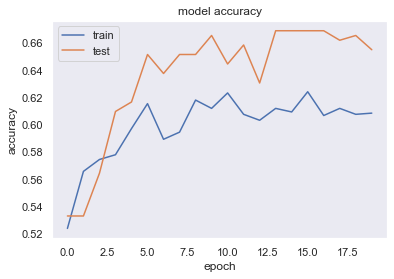

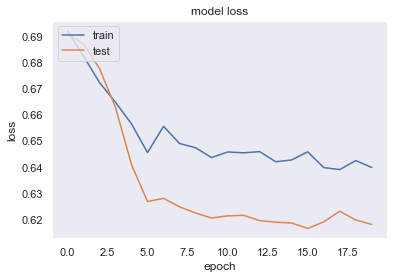

In [77]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

# Make a prediction

In [80]:
# This is a very small set of completed new data to use to make predictions.
prediction_data = ["this book is fabulous","i hated this book", "the best", "no good", "okay"]
tokenized = tokenizer.texts_to_sequences(prediction_data)
padded = sequence.pad_sequences(tokenized, padding='post', maxlen=max_len)

# Supply this data to each of your models and see how it does.
prediction = model.predict(padded)

# You can call the helper function "to_word_label" to map the output of the model to the name of the
# class it was predicted to belong to.
to_word_label(prediction)


['negative', 'negative', 'negative', 'positive', 'negative']